In [ ]:
# To clone from our personal Github mirror (may be out of sync):
!git clone https://github.com/wictorcrozeta/contadormoeda

Cloning into 'contadormoeda'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 75 (delta 10), reused 55 (delta 10), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [ ]:
# Install latest OpenCV with Python Interface using the Python Install Program
!pip3 install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%reload_ext autoreload
%autoreload 2

# Make matplotlib draw graphics directly onto the notebook and not in a window
%matplotlib inline

In [ ]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import ndimage as ndi
from skimage.util import random_noise, img_as_ubyte
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage import feature, data, color




**Carrega imagem e transforma em cinza:**

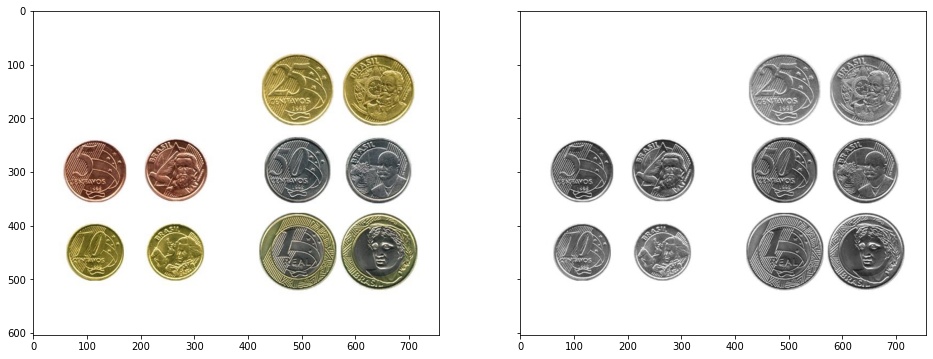

In [ ]:
# Load the image in color (OpenCV standard = BGR)
orig = cv2.imread("/content/contadormoeda/Imagens base/moedas.jpg", cv2.IMREAD_COLOR)
# Convert to RGB
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
# Load the image in grayscale
gray = cv2.imread("/content/contadormoeda/Imagens base/moedas.jpg", cv2.IMREAD_GRAYSCALE)


fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(orig)
ax[1].imshow(gray, 'gray')

**Aplicando correção gamma**

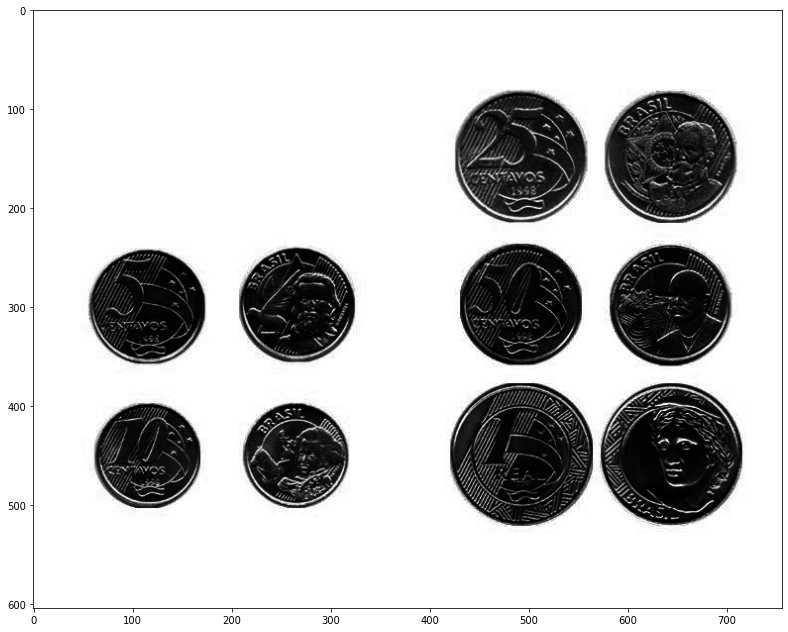

In [ ]:
gamma = 0.3
# build a lookup table mapping the pixel values [0, 255] to
invGamma = 1.0 / gamma
table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")

# apply gamma correction using the lookup table
correcaogamma = cv2.LUT(gray, table)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 11))
ax.imshow(correcaogamma, cmap=plt.cm.gray)
plt.show()


**Aplica o filtro Blur do openCV2 na imagem cinza**

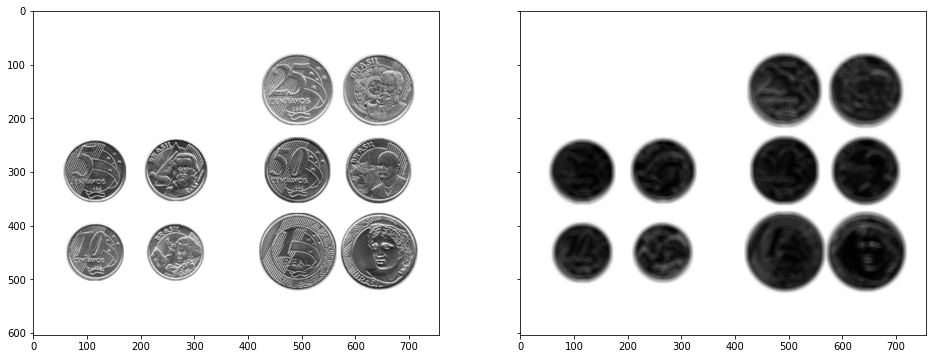

In [ ]:
# ksize
ksize = (10, 10)
  
# Using cv2.blur() method 
blur = cv2.blur(correcaogamma, ksize) 
  
# Displaying the image 
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(gray, 'gray')
ax[1].imshow(blur, 'gray')


**Aplica o filtro Canny**

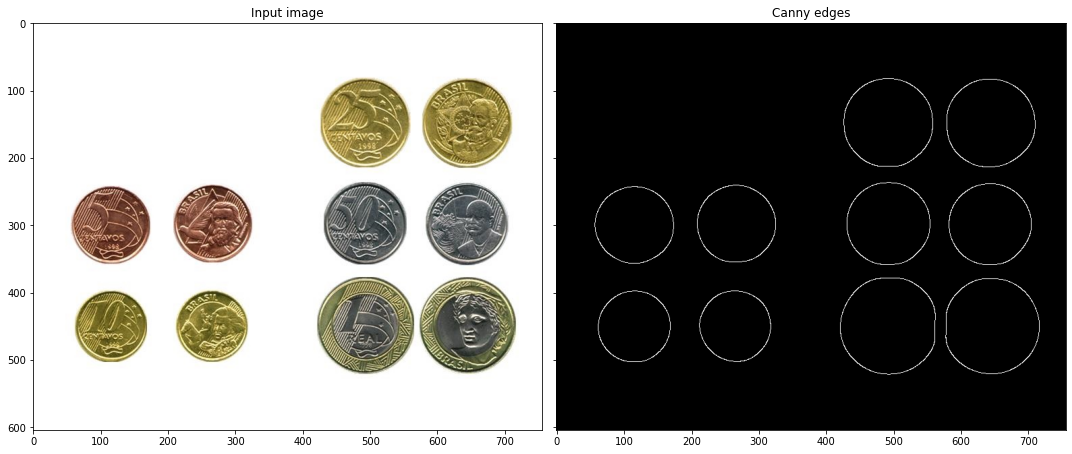

In [ ]:
# Line finding using the Probabilistic Hough Transform
edges = feature.canny(blur, sigma=7)
# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(orig)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

plt.tight_layout()
plt.show() 



**Aplicando a Transformada de Hough**

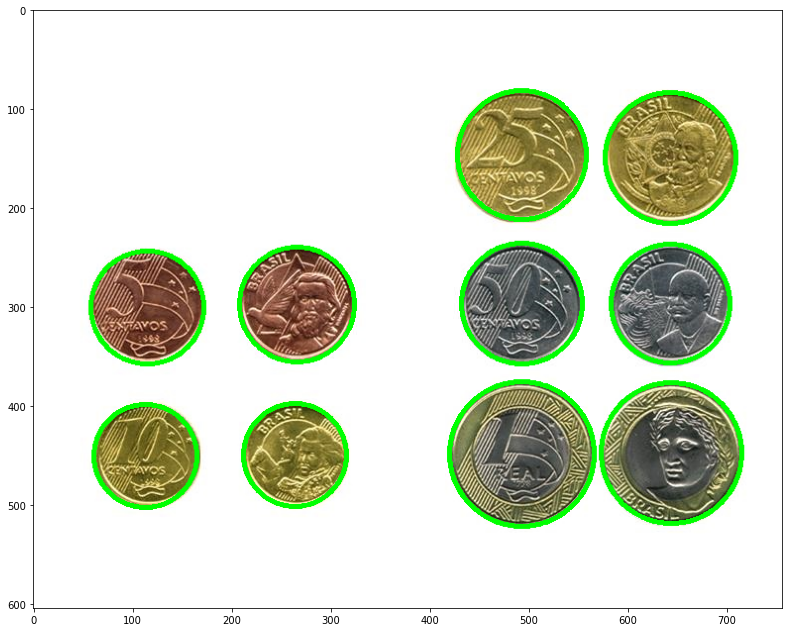

In [ ]:
# Hough Transformation
hough = cv2.HoughCircles(img_as_ubyte(edges), cv2.HOUGH_GRADIENT, 1, 80, param1=80, param2=20, minRadius=20, maxRadius=180)
# Copy image
image_copy = orig.copy()

#Radius altera o tamanho do circulo em relação a imagem, necessário ser alterado quando o ambiente mudar


# Draw them
for detected_circle in hough[0]:
    x_coor, y_coor, detected_radius = detected_circle
    coins_detected = cv2.circle(image_copy,(int(x_coor), int(y_coor)), int(detected_radius), (0, 255, 0), 4)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 11))
ax.imshow(coins_detected, cmap=plt.cm.gray)
plt.show()


In [ ]:
moedas = {
    "10 CENTAVOS": {
        "value": 0.10,
        "radius": 20,
        "ratio": 1.0,
        "count": 0,
    },
    "5 CENTAVOS": {
        "value": 0.05,
        "radius": 22,
        "ratio": 1.1,
        "count": 0,
    },
    "50 CENTAVOS": {
        "value": 0.50,
        "radius": 23,
        "ratio": 1.15,
        "count": 0,
    },
    "25 CENTAVOS": {
        "value": 0.25,
        "radius": 25,
        "ratio": 1.25,
        "count": 0,
    },
    "1 REAL": {
        "value": 1,
        "radius": 27,
        "ratio": 1.35,
        "count": 0,
    },
}

A quantia total é 2.75 reais
10 CENTAVOS = 2x
5 CENTAVOS = 1x
50 CENTAVOS = 2x
25 CENTAVOS = 2x
1 REAL = 1x


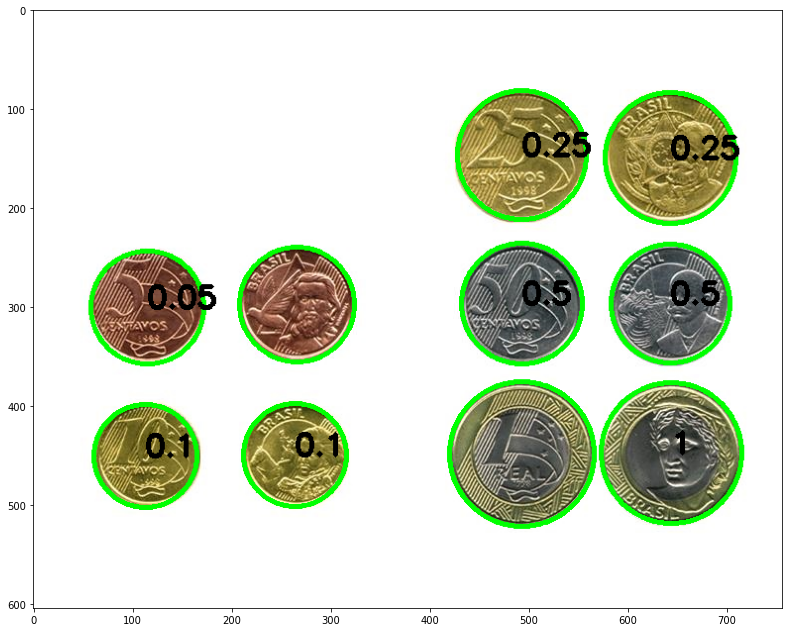

In [ ]:
radius = []
coordinates = []

for detected_circle in hough[0]:
    x_coor, y_coor, detected_radius = detected_circle
    radius.append(detected_radius)
    coordinates.append([x_coor, y_coor])

smallest = min(radius)
tolerance = 0.02375
total_amount = 0

font = cv2.FONT_HERSHEY_SIMPLEX
for coin in hough[0]:
    ratio_to_check = coin[2] / smallest
    coor_x = coin[0]
    coor_y = coin[1]
    for cents in moedas:
        value = moedas[cents]['value']
        if abs(ratio_to_check - moedas[cents]['ratio']) <= tolerance:
            moedas[cents]['count'] += 1
            total_amount += moedas[cents]['value']
            cv2.putText(image_copy, str(value), (int(coor_x), int(coor_y)), font, 1,(0, 0, 0), 4)

print(f"A quantia total é {total_amount} reais")
for cents in moedas:
    pieces = moedas[cents]['count']
    print(f"{cents} = {pieces}x")

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 11))
ax.imshow(image_copy, cmap=plt.cm.gray)
plt.show()
